<a href="https://colab.research.google.com/github/daisysong76/AI--Machine--learning/blob/main/Fine_Tuning_Alpaca_LoRA_llama_Sentiment_Analysis_on_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine -Tuning Alpaca LoRA llama: Sentiment Analysis on Diabetes Implementation

# Load Sample Dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd

# Load the Excel file
excel_file_path = '/content/drive/MyDrive/diabetes_290/Diabetes_Geo_US_No_Reddit_2023_50K_rows.xlsx'  # Update this to your Excel file's path
df = pd.read_excel(excel_file_path)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
df.head()

,Post ID,Sound Bite Text,Ratings and Scores,Title,Source Type,Post Type,Is Paid,Media Type,URL,Media Link,...,LexisNexis Company - Any,LexisNexis Person - High,LexisNexis Person - Any,LexisNexis Institution - High,LexisNexis Institution - Any,LexisNexis Subject Group 1,LexisNexis Subject 1,LexisNexis Subject Group 2,LexisNexis Subject 2,LexisNexis Other Subjects
0,https://trapperman.com/forum/ubbthreads.php/to...,I take a low dose daily as counter to my metfo...,NaN,Warning for those who take Lisinopril - Trappe...,Forums,NaN,No,No Media,https://trapperman.com/forum/ubbthreads.php/to...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1741463312586428562,@thisbttrfly @TheChiefNerd @SethMacFarlane Onl...,NaN,NaN,Twitter,Replies and Comments,No,No Media,http://twitter.com/MrShaveG/statuses/174146331...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.city-data.com/forum/diabetes/34517...,Like clockwork it seems to start around 9pm in...,NaN,Nighttime burning itch,Forums,NaN,No,No Media,https://www.city-data.com/forum/diabetes/34517...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1741485119221674188,@HashCodeSalt @thesurepath1 I come from a medi...,NaN,NaN,Twitter,Replies and Comments,No,No Media,http://twitter.com/islam_supreme/statuses/1741...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://community.whattoexpect.com/forums/may-...,Eww what a crappy doctor!!! If there was a blo...,NaN,Kinda freak out ? - May 2024 Babies | Forums |...,Forums,NaN,No,No Media,https://community.whattoexpect.com/forums/may-...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# exclude details, sources, etc at the bottom of Excel file
# dropped NaN values in 'Post ID'
df = df[~(df['Post ID'].isna())]
# remove duplicate posts
df = df.drop_duplicates('Sound Bite Text')
# previous datset is (50011, 62)

In [ ]:
# remove posts that professions contain health/medicine/hospital
df = df[df["Professions"].str.contains("Health | Medicine | Hospital", na=False)== False]
# remove posts that have followers >=10000
df = df[~(df["Followers/Daily Unique Visitors/Subscribers"]>=10000)]
df.reset_index(drop=True, inplace=True)
#data['Followers/Daily Unique Visitors/Subscribers'].describe([.25,.5,.75,.9,.93,.95])

In [ ]:
columns_to_extract = [
    'Sound Bite Text', 'Sentiment', 'Title', 'Source Type',
    'Post Type',
    'Published Date (GMT-05:00) New York',
    'Author Location - Country 1'
]

In [ ]:
df_extracted = df[columns_to_extract]
df_extracted.head()

,Sound Bite Text,Sentiment,Title,Source Type,Post Type,Published Date (GMT-05:00) New York,Author Location - Country 1
0,I take a low dose daily as counter to my metfo...,Neutrals,Warning for those who take Lisinopril - Trappe...,Forums,NaN,"Dec 31, 2023 12:00:00 AM",United States
1,@thisbttrfly @TheChiefNerd @SethMacFarlane Onl...,Neutrals,NaN,Twitter,Replies and Comments,"Dec 31, 2023 9:16:23 AM",United States
2,Like clockwork it seems to start around 9pm in...,Neutrals,Nighttime burning itch,Forums,NaN,"Dec 30, 2023 10:35:00 AM",United States
3,@HashCodeSalt @thesurepath1 I come from a medi...,Neutrals,NaN,Twitter,Replies and Comments,"Dec 31, 2023 10:43:02 AM",United States
4,Eww what a crappy doctor!!! If there was a blo...,Neutrals,Kinda freak out ? - May 2024 Babies | Forums |...,Forums,NaN,"Dec 31, 2023 12:36:00 AM",United States


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
df = df_extracted
# Basic text cleaning (more thorough cleaning might be required)
df['Cleaned_Text'] = df['Sound Bite Text'].str.replace(r'http\S+', '', regex=True).str.replace('[^a-zA-Z]', ' ', regex=True).str.lower()
df.head()

,Sound Bite Text,Sentiment,Title,Source Type,Post Type,Published Date (GMT-05:00) New York,Author Location - Country 1,Cleaned_Text
0,I take a low dose daily as counter to my metfo...,Neutrals,Warning for those who take Lisinopril - Trappe...,Forums,NaN,"Dec 31, 2023 12:00:00 AM",United States,i take a low dose daily as counter to my metfo...
1,@thisbttrfly @TheChiefNerd @SethMacFarlane Onl...,Neutrals,NaN,Twitter,Replies and Comments,"Dec 31, 2023 9:16:23 AM",United States,thisbttrfly thechiefnerd sethmacfarlane onl...
2,Like clockwork it seems to start around 9pm in...,Neutrals,Nighttime burning itch,Forums,NaN,"Dec 30, 2023 10:35:00 AM",United States,like clockwork it seems to start around pm in...
3,@HashCodeSalt @thesurepath1 I come from a medi...,Neutrals,NaN,Twitter,Replies and Comments,"Dec 31, 2023 10:43:02 AM",United States,hashcodesalt thesurepath i come from a medi...
4,Eww what a crappy doctor!!! If there was a blo...,Neutrals,Kinda freak out ? - May 2024 Babies | Forums |...,Forums,NaN,"Dec 31, 2023 12:36:00 AM",United States,eww what a crappy doctor if there was a blo...


In [ ]:
columns_to_extract = [
    'Sentiment','Cleaned_Text'
]

In [ ]:
df_extracted = df[columns_to_extract]
df_extracted.head()

,Sentiment,Cleaned_Text
0,Neutrals,i take a low dose daily as counter to my metfo...
1,Neutrals,thisbttrfly thechiefnerd sethmacfarlane onl...
2,Neutrals,like clockwork it seems to start around pm in...
3,Neutrals,hashcodesalt thesurepath i come from a medi...
4,Neutrals,eww what a crappy doctor if there was a blo...


In [ ]:
df = df_extracted

In [ ]:
# Convert the DataFrame to a JSON string
json_str = df.to_json(orient='records')

# Optionally, save the JSON data to a file
json_file_path = '/content/drive/MyDrive/diabetes_290/Diabetes_Geo_US_No_Reddit_2023_50K_rows.json'  # Update this to your desired JSON file path
with open(json_file_path, 'w') as json_file:
    json_file.write(json_str)

# If you want the JSON output to be more readable, you can use:
pretty_json_str = df.to_json(orient='records', indent=4)
# and then write `pretty_json_str` to a file as shown above.

In [2]:
!pip install -q datasets

In [3]:
from datasets import load_dataset

#JSON file path
diabetes_path='/content/drive/MyDrive/diabetes_290/Diabetes_Geo_US_No_Reddit_2023_50K_rows.json'

diabetes = load_dataset('json', data_files=diabetes_path)

In [ ]:
print(diabetes)
print(type(diabetes))

DatasetDict({
    train: Dataset({
        features: ['Sentiment', 'Cleaned_Text'],
        num_rows: 37267
    })
})
<class 'datasets.dataset_dict.DatasetDict'>


In [9]:
diabetes['train'][0].keys()

dict_keys(['Sentiment', 'Cleaned_Text'])

In [ ]:
df.Sentiment.value_counts()

Neutrals     34875
Positives     1317
Negatives      998
Mixed           71
Name: Sentiment, dtype: int64

<Axes: >

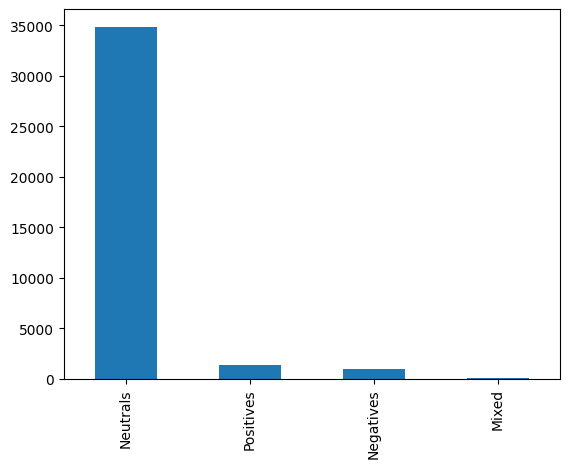

In [ ]:
df.Sentiment.value_counts().plot(kind='bar')

In [4]:
dataset_data=[
    {
        "instruction": "Detect the sentiment of the sentence below",
        "input": row_dict['Cleaned_Text'],
        "output": row_dict['Sentiment']
    }
    for row_dict in diabetes['train']
]

In [5]:
dataset_data[0]

{'instruction': 'Detect the sentiment of the sentence below',
 'input': 'i take a low dose daily as counter to my metformin for high blood sugar  jim',
 'output': 'Neutrals'}

In [6]:
import json

# Assuming dataset_data is a Python dictionary or a list of dictionaries that you want to save as JSON
with open("dataset_data.json", "w") as f:
    json.dump(dataset_data, f)

    ### instruction:
    {instruction}

    ### input:
    {dataset_data['input']}

    ### output:
    {dataset_data['output']}

# Install Dependencies

In [7]:
!pip install -q bitsandbytes loralib
!pip install -q git+https://github.com/huggingface/peft.git git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/huggingface/accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-ci22fo9p
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-ci22fo9p
  Resolved https://github.com/huggingface/accelerate to commit 2ad42e77c3a1993dbfb9bc299c21bae2005c0572
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#### Confirm CUDA

In [8]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-crede

In [ ]:
import torch
torch.cuda.is_available()

True

In [9]:
import os

HF_TOKEN = os.getenv("HUGGING_FACE_TOKEN")


# Load Base Model

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM


In [11]:
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    torch_dtype=torch.float16, # half-precision floating point, reduced precision means that calculations require less computational power.
    device_map='auto', #the model to automatically determine the best way to distribute its different components across the available devices in your system
    load_in_8bit=True
)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
#from transformers import BitsAndBytesConfig

#model_name = "meta-llama/Llama-2-7b-chat-hf"
#quantization_config = BitsAndBytesConfig(quantize_on_load=True)  # Enable quantization on load

#model = AutoModelForCausalLM.from_pretrained(
    #model_name,
    #torch_dtype=torch.float16,  # Use half-precision floating point
    #device_map='auto',  # Automatically distribute model components
    #quantization_config=quantization_config  # New way to specify quantization
#)

In [12]:
tokenizer.pad_token = tokenizer.eos_token

In [13]:
tokenizer.pad_token_id=(
    0
)
tokenizer.padding_side = "left"

Error solved : https://github.com/huggingface/transformers/issues/23165

##### View Model Summary

In [ ]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear8bitLt(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear8bitLt(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
 

In [14]:
data = load_dataset("json", data_files="dataset_data.json")

Generating train split: 0 examples [00:00, ? examples/s]

In [15]:
data

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 37267
    })
})

In [16]:
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  #in original code, False.
  #param.requires_grad = True
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float16)

model.gradient_checkpointing_enable()  # reduces memory usage in training by storing fewer intermediate activations, recomputing them as needed during backpropagation.

In [17]:
class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)#ensure that the final outputs of the model are in full precision (torch.float32).
model.lm_head = CastOutputToFloat(model.lm_head)

# Helper Function

In [18]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [25]:
print_trainable_parameters(model) # because model freezing

trainable params: 0 || all params: 6738415616 || trainable%: 0.0


# Obtain LoRA Model

In [19]:
#integrating LoRA (Locally Reweighted Attention) into a pre-existing language model using the PEFT,
#This library provides tools and functionalities to apply parameter-efficient fine-tuning methods, like LoRA, to large language models
from peft import LoraConfig, get_peft_model

#If only targeting attention blocks of the model
target_modules = ["q_proj", "v_proj"]#specifically the query projection (q_proj) and value projection (v_proj) components.
#This selective tuning enhances model performance or adapts it to specific tasks without changing the overall architecture.

#If targeting all linear layers
# target_modules = ['q_proj','k_proj','v_proj','o_proj','gate_proj','down_proj','up_proj','lm_head']
#In transformer models, the attention mechanism is a key component that helps the model to focus on different parts of the input sequence when making predictions.
#The attention mechanism in these models typically consists of three main parts: query (q), key (k), and value (v).

configLora = LoraConfig(
    r=16, #attention head, 8->16, rank is also the attention head,the number of trainable parameters.
    lora_alpha=16, #alpha scaling
    # target_modules=["query_key_value"],
    target_modules=target_modules,
    lora_dropout=0.05, #to the LoRA parameters to prevent overfitting
    bias="none",
    task_type="CAUSAL_LM"
)

model_peft_lora = get_peft_model(model, configLora)
print_trainable_parameters(model_peft_lora)
#A lower rank imposes a stronger regularization, potentially leading to more generalizable adaptations but with a limited capacity to capture complex modifications.
#A higher rank increases the capacity for complex adaptations but may lead to overfitting if not carefully managed.

trainable params: 8388608 || all params: 6746804224 || trainable%: 0.12433454005023165


In [20]:
def create_prompt_diabetes_1(instruction, input, output):
    # Check if 'output' is a dictionary and has the key 'text', and that 'text' is not empty
    if isinstance(output, dict) and "text" in output and len(output["text"]) > 0:
        # Assuming 'text' is a list and we want the first item
        output_text = output["text"][0]
    else:
        # Handle the case where 'output' is not as expected
        output_text = "I don't know"  # Default/fallback output text

    prompt_template = f"### instruction\n{instruction}\n### input\n{input}\n### output\n{output_text}</s>"
    return prompt_template

# Assuming dataset_data is structured correctly and 'output' key exists in each sample
mapped_raw_dataset = list(map(
    lambda sample: tokenizer(create_prompt_diabetes_1(sample['instruction'], sample['input'], sample['output'])),
    dataset_data
))


### we can just fine tune the model with raw data. we can try to reformat the data with the question and answer

In [28]:
mapped_raw_dataset[0]

{'input_ids': [1, 835, 15278, 13, 6362, 522, 278, 19688, 310, 278, 10541, 2400, 13, 2277, 29937, 1881, 13, 29875, 2125, 263, 4482, 437, 344, 14218, 408, 6795, 304, 590, 1539, 689, 262, 363, 1880, 10416, 26438, 29871, 432, 326, 13, 2277, 29937, 1962, 13, 29902, 1016, 29915, 29873, 1073, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
train_val = data["train"].train_test_split(test_size=0.1, shuffle=True, seed=42)

In [ ]:
train_data = train_val["train"].shuffle().map(create_prompt_diabetes_1)

In [29]:
import gc
gc.collect()

0

In [21]:
from accelerate import Accelerator, DataLoaderConfiguration

dataloader_config = DataLoaderConfiguration(
    dispatch_batches=None,
    split_batches=False,
    even_batches=True,
    use_seedable_sampler=True
)

accelerator = Accelerator(dataloader_config=dataloader_config)

In [22]:
import transformers

tokenizer.pad_token = tokenizer.eos_token
# 3 times of memorywhen I run training, become I am using adamw
# 7b*2*3=42b
# adamw
# https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html

# tokenizer.add_special_tokens({'pad_token': '[PAD]'})

trainer = transformers.Trainer(
    model= model_peft_lora,
    train_dataset=mapped_raw_dataset,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,
        warmup_steps=100,
        max_steps=100,
        learning_rate=1e-3,
        fp16=True,
        logging_steps=1,
        output_dir='outputs',
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False, pad_to_multiple_of=8) # pad_to_multiple_of
)
model.config.use_cache = False

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [23]:
for param in model.parameters():
    if param.dtype.is_floating_point or param.dtype.is_complex:
        param.requires_grad = True

In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    fp16=True,                       # Enable mixed precision
    # Other arguments
)

In [29]:
model_name = "llama-2-7b-lora-diabetes-v1"
username = "daisysxm76"  # Replace with your Hugging Face Hub username

# Login via the CLI first or ensure your HF_HOME environment variable has the token

# Push to hub
model_peft_lora.push_to_hub(f"{username}/{model_name}", use_auth_token=True)
tokenizer.push_to_hub(f"{username}/{model_name}", use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:834: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/daisysxm76/llama-2-7b-lora-diabetes-v1/commit/0e50fe9b287868aaaeebfe2a463f2b3f4f626ded', commit_message='Upload tokenizer', commit_description='', oid='0e50fe9b287868aaaeebfe2a463f2b3f4f626ded', pr_url=None, pr_revision=None, pr_num=None)

# Train LoRA

In [26]:
!pip show accelerate

Name: accelerate
Version: 0.29.0.dev0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: peft


In [ ]:
trainer.train()

In [ ]:
from accelerate import prepare

optimizer = AdamW(model.parameters(), lr=5e-5)

model, optimizer, train_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader
)

# Example training loop
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Process your inputs...

        outputs = model(**inputs)
        loss = outputs.loss

        # Use accelerator.backward() for the backward pass
        accelerator.backward(loss)

        optimizer.step()
        optimizer.zero_grad()


input_ids represent the numerical representations of the tokens

attention_mask is used to ignore padded tokens in sequences.

-------

In [ ]:
from IPython.display import display, Markdown

def make_inference(context, question, model, tokenizer):
    batch = tokenizer(f"### CONTEXT\n{context}\n\n### QUESTION\n{question}\n\n### ANSWER\n", return_tensors='pt')

    batch = batch.to('cuda') if torch.cuda.is_available() else batch

    with torch.cuda.amp.autocast():
        output_tokens = model.generate(**batch, max_new_tokens=200)

    display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))


In [ ]:
context = "Cheese is the best food."
question = "What is the best food?"

make_inference(context, question, model=qa_model_3, tokenizer=tokenizer)

In [ ]:
marketmail_model = PeftModel.from_pretrained(model, "c-s-ale/bloom-7b1-marketmail-ai")

In [ ]:
from IPython.display import display, Markdown

def make_inference_mm_ai(product, description):
  batch = tokenizer(f"Below is a product and description, please write a marketing email for this product.\n\n### Product:\n{product}\n### Description:\n{description}\n\n### Marketing Email:\n", return_tensors='pt')

  with torch.cuda.amp.autocast():
    output_tokens = marketmail_model.generate(**batch, max_new_tokens=200)

  display(Markdown((tokenizer.decode(output_tokens[0], skip_special_tokens=True))))

In [ ]:
your_product_name_here = "The Coolinator"
your_product_description_here = "A personal cooling device to keep you from getting overheated on a hot summer's day!"

make_inference_mm_ai(your_product_name_here, your_product_description_here)